In [ ]:
from collections import Counter
from wordcloud import WordCloud

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from surprise.model_selection import train_test_split,cross_validate
from surprise import SVD, accuracy
from surprise import KNNBasic
import os
from tensorflow.keras import backend as K
import tables

import tensorflow as tf

2023-04-27 19:19:18.958463: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 19:19:20.959872: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# lyrics_data_org = pd.read_csv(r"/home/016651544/datasets/mxm_dataset.csv")
# lyrics_data_org.head()

In [6]:
mxm_matches = pd.read_csv(r"/home/016651544/datasets/mxm_779k_matches.csv")
mxm_matches.head()

,track_id,artist name,titleMSD,mxm_track_id,artist_name,titleMXM
0,TRMMMKD128F425225D,Karkkiautomaatti,Tanssi vaan,4418550,Karkkiautomaatti,Tanssi vaan
1,TRMMMRX128F93187D9,Hudson Mohawke,No One Could Ever,8898149,Hudson Mohawke,No One Could Ever
2,TRMMMCH128F425532C,Yerba Brava,Si Vos Querés,9239868,Yerba Brava,Si vos queres
3,TRMMMXN128F42936A5,David Montgomery,"Symphony No. 1 G minor ""Sinfonie Serieuse""/All...",5346741,Franz Berwald,"Symphony No. 1 in G minor ""Sinfonie Sérieuse"":..."
4,TRMMMBB12903CB7D21,Kris Kross,2 Da Beat Ch'yall,2511405,Kris Kross,2 Da Beat Ch'yall


In [7]:
lyrics_train = pd.read_csv(r'/home/016651544/datasets/mxm_dataset_train.csv')
lyrics_test = pd.read_csv(r'/home/016651544/datasets/mxm_dataset_test.csv')
display(lyrics_train.head())
display(lyrics_test.head())
print(lyrics_train.shape)
print(lyrics_test.shape)

,track_id,mxm_track_id,word_count
0,TRAAAAV128F421A322,4623710,"{'i': 6, 'the': 4, 'you': 2, 'to': 2, 'and': 5..."
1,TRAAABD128F429CF47,6477168,"{'i': 10, 'you': 17, 'to': 8, 'and': 2, 'a': 2..."
2,TRAAAED128E0783FAB,2516445,"{'i': 28, 'the': 15, 'you': 2, 'to': 12, 'and'..."
3,TRAAAEF128F4273421,3759847,"{'i': 5, 'the': 4, 'you': 3, 'to': 2, 'and': 1..."
4,TRAAAEW128F42930C0,3783760,"{'i': 4, 'to': 5, 'and': 7, 'a': 2, 'me': 4, '..."


,track_id,mxm_track_id,word_count
0,TRAABRX12903CC4816,1548880,"{'the': 19, 'to': 7, 'and': 6, 'in': 1, 'is': ..."
1,TRAADFO128F92E1E91,5325944,"{'i': 79, 'the': 66, 'you': 15, 'to': 7, 'and'..."
2,TRAADQW128F427CE68,3811449,"{'i': 3, 'the': 3, 'you': 2, 'me': 4, 'it': 1,..."
3,TRAADRX12903D0EFE8,5583484,"{'i': 1, 'a': 5, 'me': 1, 'in': 1, 'come': 1, ..."
4,TRAAEJQ128F92C484E,9124657,"{'i': 28, 'the': 7, 'you': 12, 'to': 3, 'and':..."


(210519, 3)
(27143, 3)


In [8]:
lyrics_train['word_count'] =  lyrics_train['word_count'].apply(eval)

In [9]:
# calculate total number of words and unique words in each song
lyrics_train['total_words'] = lyrics_train['word_count'].apply(lambda x: sum(x.values())) 
lyrics_train['total_unique_words'] = lyrics_train['word_count'].apply(lambda x: len(x.keys()))

In [10]:
avg_word_count = lyrics_train['total_words'].mean()

In [11]:


# calculate most common words across all songs
word_counts = {}
for wc in lyrics_train['word_count']:
    for word, count in wc.items():
        if word not in word_counts:
            word_counts[word] = count
        else:
            word_counts[word] += count
top_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:10]


In [12]:
lyrics_train.total_words.value_counts()

152     956
136     915
173     914
162     910
143     902
       ... 
1057      1
1196      1
3195      1
1086      1
963       1
Name: total_words, Length: 1150, dtype: int64

In [14]:
lyrics_train.isna().sum()

track_id              0
mxm_track_id          0
word_count            0
total_words           0
total_unique_words    0
dtype: int64

In [15]:
lyrics_train.loc[:,'lyrics'] = lyrics_train['word_count'].apply(lambda x: " ".join(list(x.keys())))

In [16]:
lyrics_train.head()

,track_id,mxm_track_id,word_count,total_words,total_unique_words,lyrics
0,TRAAAAV128F421A322,4623710,"{'i': 6, 'the': 4, 'you': 2, 'to': 2, 'and': 5...",103,68,i the you to and a me it my is of your that ar...
1,TRAAABD128F429CF47,6477168,"{'i': 10, 'you': 17, 'to': 8, 'and': 2, 'a': 2...",226,74,i you to and a me it not in my is your that do...
2,TRAAAED128E0783FAB,2516445,"{'i': 28, 'the': 15, 'you': 2, 'to': 12, 'and'...",421,120,i the you to and a me it not in my is of that ...
3,TRAAAEF128F4273421,3759847,"{'i': 5, 'the': 4, 'you': 3, 'to': 2, 'and': 1...",139,59,i the you to and a not is of that do are for k...
4,TRAAAEW128F42930C0,3783760,"{'i': 4, 'to': 5, 'and': 7, 'a': 2, 'me': 4, '...",115,63,i to and a me not in my that on am all with li...


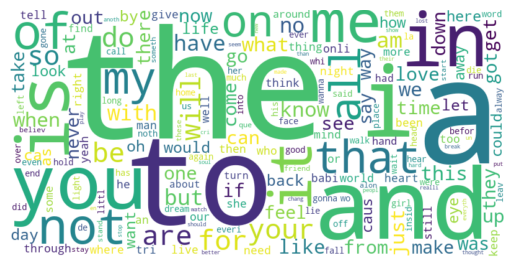

In [20]:
# Visualize the most common words
word_counts = Counter()
for word_list in lyrics_train['word_count']:
    for word in word_list.keys():
        word_counts[word] += 1

wc = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(word_counts)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


### METADATA 

In [21]:
# Convert the table to a Pandas DataFrame
metadata_table_df = pd.read_csv('/home/016651544/datasets/track_metadata.csv')
metadata_table_df.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003,7032331,-1,0
1,TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995,1514808,-1,0
2,TRMMMRX128F93187D9,No One Could Ever,SOGTUKN12AB017F4F1,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97098,0.643681,0.437504,2006,6945353,-1,0
3,TRMMMCH128F425532C,Si Vos Querés,SOBNYVR12A8C13558C,De Culo,ARNWYLR1187B9B2F9C,12be7648-7094-495f-90e6-df4189d68615,Yerba Brava,145.05751,0.448501,0.372349,2003,2168257,-1,0
4,TRMMMWA128F426B589,Tangle Of Aspens,SOHSBXH12A8C13B0DF,Rene Ablaze Presents Winter Sessions,AREQDTE1269FB37231,NaN,Der Mystic,514.29832,0.000000,0.000000,0,2264873,-1,0


In [22]:
metadata_table_df = metadata_table_df.applymap(lambda x: x.decode('utf-8').strip('\'"') if isinstance(x, bytes) else x)
metadata_table_df.isna().sum()

track_id                  0
title                    15
song_id                   0
release                   5
artist_id                 0
artist_mbid           62571
artist_name               0
duration                  0
artist_familiarity        0
artist_hotttnesss         0
year                      0
track_7digitalid          0
shs_perf                  0
shs_work                  0
dtype: int64

In [23]:
# len(set(metadata_table_df.track_id) -set(lyrics_train.track_id) -set(lyrics_test.track_id))
len(set(metadata_table_df.artist_name) -set(mxm_matches.artist_name))
# lyrics_train[lyrics_train.track_id.str.contains('TRMMM')]

41096

In [56]:
meta_cols = ['track_id', 'artist_familiarity', 'artist_hotttnesss','release','title', 'artist_name']
lyrics_metadata= pd.merge(metadata_table_df[meta_cols],lyrics_train,on='track_id',how='right')
print(lyrics_metadata.shape,lyrics_train.shape,lyrics_metadata.track_id.nunique())
lyrics_metadata.head()

(210519, 11) (210519, 6) 210519


,track_id,artist_familiarity,artist_hotttnesss,release,title,artist_name,mxm_track_id,word_count,total_words,total_unique_words,lyrics
0,TRAAAAV128F421A322,0.671755,0.386606,Cognicide,A Poor Recipe For Civic Cohesion,Western Addiction,4623710,"{'i': 6, 'the': 4, 'you': 2, 'to': 2, 'and': 5...",103,68,i the you to and a me it my is of your that ar...
1,TRAAABD128F429CF47,0.630630,0.417500,Dimensions,Soul Deep,The Box Tops,6477168,"{'i': 10, 'you': 17, 'to': 8, 'and': 2, 'a': 2...",226,74,i you to and a me it not in my is your that do...
2,TRAAAED128E0783FAB,0.786806,0.562061,Twentysomething,It's About Time,Jamie Cullum,2516445,"{'i': 28, 'the': 15, 'you': 2, 'to': 12, 'and'...",421,120,i the you to and a me it not in my is of that ...
3,TRAAAEF128F4273421,0.630382,0.454231,Friend Or Foe,Something Girls,Adam Ant,3759847,"{'i': 5, 'the': 4, 'you': 3, 'to': 2, 'and': 1...",139,59,i the you to and a not is of that do are for k...
4,TRAAAEW128F42930C0,0.589697,0.378545,Inside / Absent,Burn My Body (Album Version),Broken Spindles,3783760,"{'i': 4, 'to': 5, 'and': 7, 'a': 2, 'me': 4, '...",115,63,i to and a me not in my that on am all with li...


In [57]:
lyrics_metadata.dropna(inplace=True)
lyrics_metadata.isna().sum(),lyrics_metadata.columns


(track_id              0
 artist_familiarity    0
 artist_hotttnesss     0
 release               0
 title                 0
 artist_name           0
 mxm_track_id          0
 word_count            0
 total_words           0
 total_unique_words    0
 lyrics                0
 dtype: int64,
 Index(['track_id', 'artist_familiarity', 'artist_hotttnesss', 'release',
        'title', 'artist_name', 'mxm_track_id', 'word_count', 'total_words',
        'total_unique_words', 'lyrics'],
       dtype='object'))

### EDA

In [59]:
def remove_outliers(df,column_name):
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    print(q1, q3,lower, upper)

    # Identify and remove outliers based on IQR
    print("Before removing outliers from {} shape of df:- ".format(column_name),df.shape)
    df = df[(df[column_name] >= lower) & (df[column_name] <= upper)]
    print("After removing outliers from {} shape of df:- ".format(column_name),df.shape)
    return df
lyrics_metadata = remove_outliers(lyrics_metadata,'artist_familiarity')
lyrics_metadata = remove_outliers(lyrics_metadata,'artist_hotttnesss')
lyrics_metadata = remove_outliers(lyrics_metadata,'total_words')



       artist_familiarity  artist_hotttnesss
count       192805.000000      192805.000000
mean             0.640025           0.446819
std              0.106834           0.080830
min              0.336066           0.205026
25%              0.567421           0.387751
50%              0.634928           0.438759
75%              0.712735           0.504449
max              0.941896           0.690915


array([[<Axes: title={'center': 'artist_familiarity'}>,
        <Axes: title={'center': 'artist_hotttnesss'}>]], dtype=object)

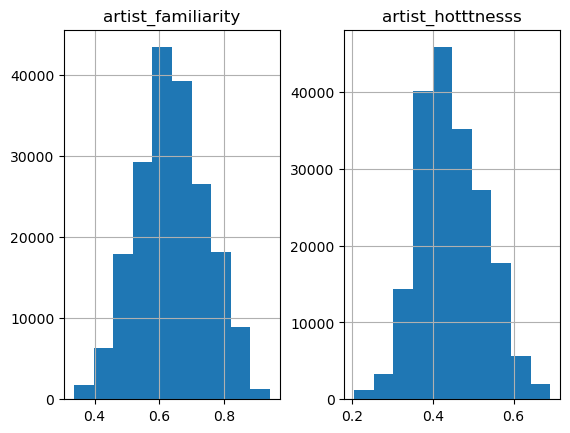

In [60]:
print(lyrics_metadata[['artist_familiarity','artist_hotttnesss']].describe())
lyrics_metadata[['artist_familiarity','artist_hotttnesss']].hist()

Unique releases: 49841
Most common releases:
 Greatest Hits              625
Live                       309
The Collection             252
The Ultimate Collection    235
Anthology                  188
The Very Best Of           178
Gold                       172
Original Album Classics    170
Best Of                    169
Super Hits                 159
Name: release, dtype: int64


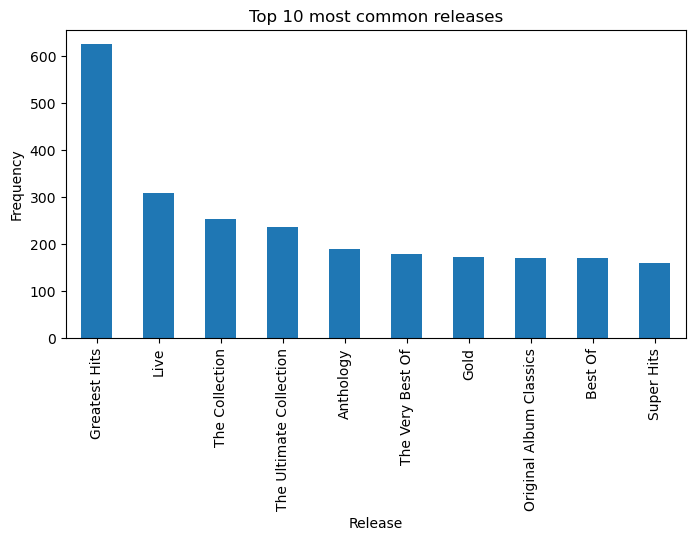

In [61]:
# Check unique values and frequency distribution of release
print("Unique releases:", lyrics_metadata['release'].nunique())
print("Most common releases:\n", lyrics_metadata['release'].value_counts().head(10))

# Plot bar chart of top 10 releases
plt.figure(figsize=(8,4))
lyrics_metadata['release'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 most common releases")
plt.xlabel("Release")
plt.ylabel("Frequency")
plt.show()


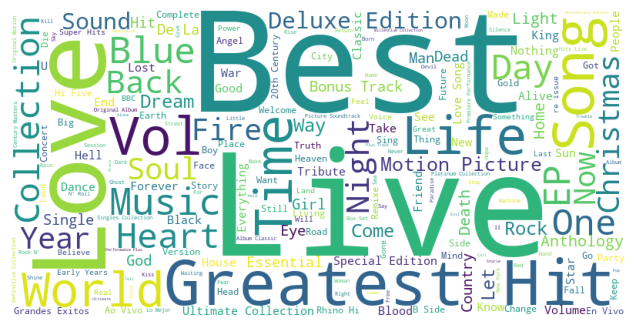

In [62]:
# Create word cloud of release
plt.figure(figsize=(8,4))
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(' '.join(lyrics_metadata['release']))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Unique titles: 158352
Most common titles:
 Intro              161
Home                63
Goodbye             49
You                 49
Hold On             48
Time                46
Angel               45
Silent Night        44
Tonight             44
White Christmas     43
Name: title, dtype: int64


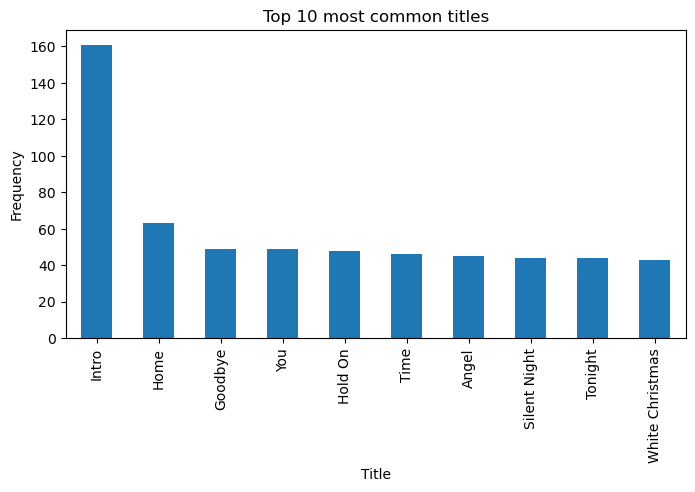

In [63]:
# Check unique values and frequency distribution of title
print("Unique titles:", lyrics_metadata['title'].nunique())
print("Most common titles:\n", lyrics_metadata['title'].value_counts().head(10))
# Plot bar chart of top 10 titles
plt.figure(figsize=(8,4))
lyrics_metadata['title'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 most common titles")
plt.xlabel("Title")
plt.ylabel("Frequency")
plt.show()



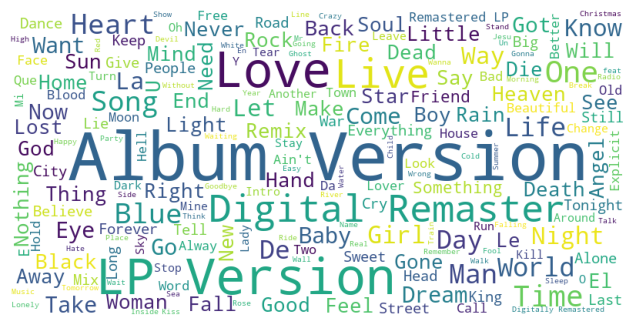

In [64]:
# Create word cloud of title
plt.figure(figsize=(8,4))
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(' '.join(lyrics_metadata['title']))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Unique artists: 17832
Most common artists:
 Carly Simon       132
Neil Diamond      112
Less Than Jake    111
Frank Sinatra     111
The Cure          110
The Hollies       110
Joan Baez         109
James Taylor      109
Willie Nelson     107
Aerosmith         103
Name: artist_name, dtype: int64


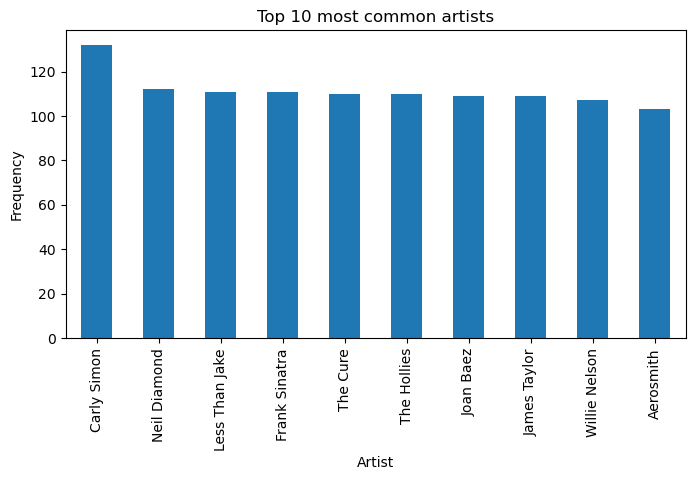

In [65]:
# Check unique values and frequency distribution of artist_name
print("Unique artists:", lyrics_metadata['artist_name'].nunique())
print("Most common artists:\n", lyrics_metadata['artist_name'].value_counts().head(10))

# Plot bar chart of top 10 artists
plt.figure(figsize=(8,4))
lyrics_metadata['artist_name'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 most common artists")
plt.xlabel("Artist")
plt.ylabel("Frequency")
plt.show()


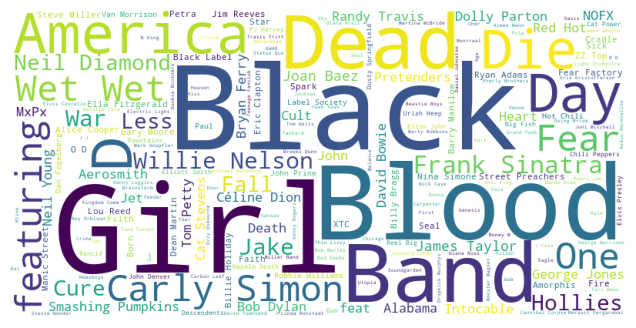

In [66]:
# Create word cloud of artist_name
plt.figure(figsize=(8,4))
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(' '.join(lyrics_metadata['artist_name']))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

/tmp/ipykernel_126005/1047088636.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = lyrics_metadata.corr()


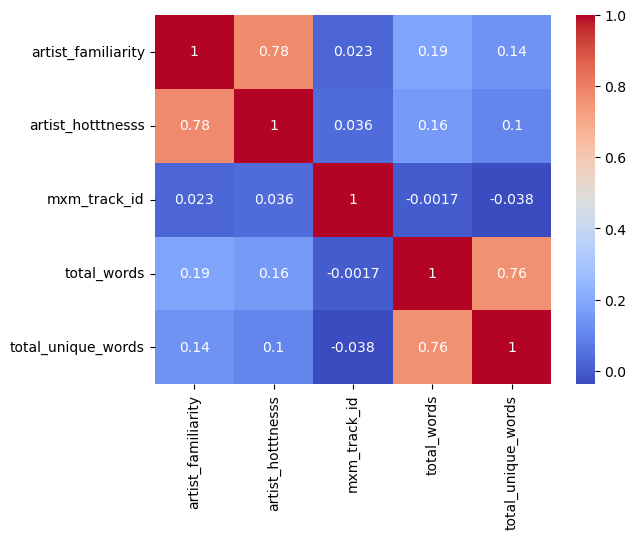

In [67]:
# Calculate correlation matrix
corr = lyrics_metadata.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

         total_words  total_unique_words
count  192805.000000       192805.000000
mean      191.670418           74.317201
std        94.314195           31.743209
min         1.000000            1.000000
25%       123.000000           54.000000
50%       181.000000           72.000000
75%       250.000000           92.000000
max       468.000000          274.000000


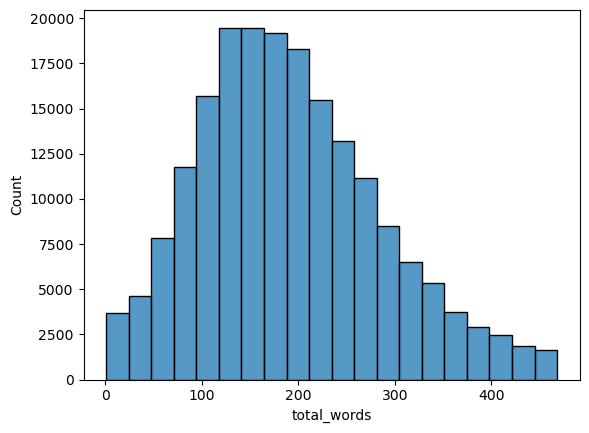

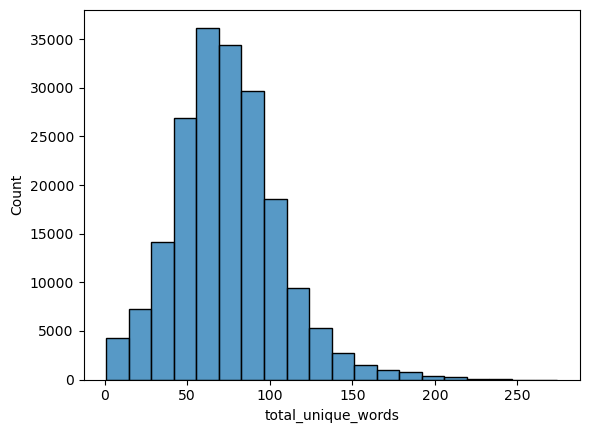

In [68]:
import seaborn as sns
# Calculate summary statistics
print(lyrics_metadata[["word_count", "total_words", "total_unique_words"]].describe())
# Plot histograms of the variables
sns.histplot(data=lyrics_metadata, x="total_words", bins=20)
plt.show()
sns.histplot(data=lyrics_metadata, x="total_unique_words", bins=20)
plt.show()

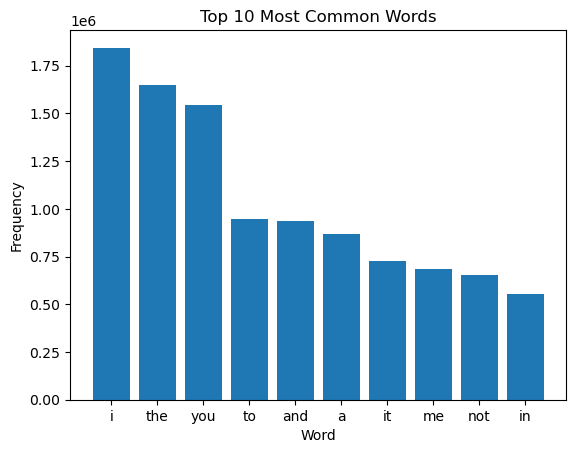

In [69]:
# plot bar chart of top 10 most common words
plt.bar(range(10), [count for word, count in top_words])
plt.xticks(range(10), [word for word, count in top_words])
plt.title('Top 10 Most Common Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.show()

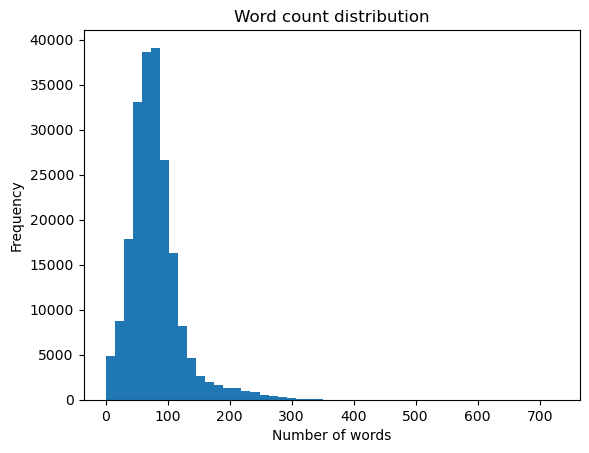

In [70]:
plt.hist(lyrics_train['word_count'].apply(lambda x: len(x)), bins=50)
plt.title("Word count distribution")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

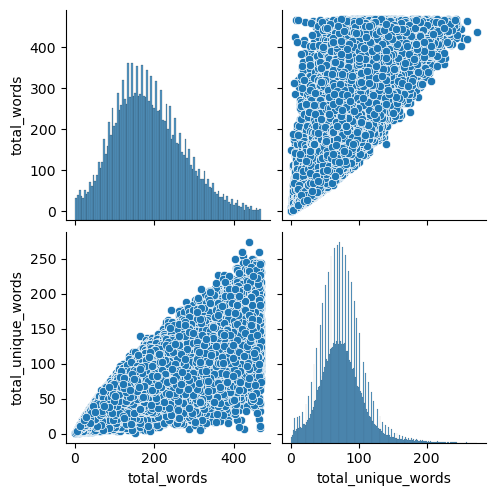

In [71]:
# Plot pairwise scatterplots to check for correlations
sns.pairplot(data=lyrics_metadata[["total_words", "total_unique_words"]])
plt.show()


### PREPROCESS TEXT

In [81]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# # download stopwords and stemmer
# nltk.download('stopwords')
# nltk.download('punkt')

In [90]:
# define stop words to remove
stop_words = set(stopwords.words('english'))
# define function for preprocessing
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [91]:
from gensim.models import Word2Vec

lyrics_metadata['text'] = lyrics_metadata[['release','title', 'artist_name','lyrics']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
lyrics_metadata['text'] = lyrics_metadata['text'].apply(remove_stopwords)

In [145]:
from sklearn.feature_extraction.text import CountVectorizer
# Vectorize the lyrics text data
vectorizer = CountVectorizer(max_features=500)

lyrics_text = vectorizer.fit_transform(lyrics_metadata['text'])

# Combine the encoded categorical variables and the vectorized lyrics text data
input1 = np.hstack([
    lyrics_metadata[['total_words', 'total_unique_words']].values,
    lyrics_text.toarray()
])
input2 = lyrics_metadata['artist_familiarity'].values

y1 = lyrics_metadata['artist_hotttnesss'].values
y2 = lyrics_metadata['artist_hotttnesss'].values
input1.shape

(192805, 502)

In [146]:
# Generate random indices
num_samples = X.shape[0]
indices = np.random.permutation(num_samples)

# Split indices into train and test
train_size = int(0.8 * num_samples)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Use indices to index data
X1_train = input1[train_indices]
X2_train = input2[train_indices]
y1_train = y[train_indices]
y2_train = y[train_indices]

X1_test = input1[test_indices]
X2_test = input2[test_indices]
y1_test = y[test_indices]
y2_test = y[test_indices]

X1_train.shape,X2_train.shape,X1_test.shape,X2_test.shape

((154244, 502), (154244,), (38561, 502), (38561,))

### NEURAL NETWORK with multiple inputs and outputs

In [147]:
max_words= X1_train.shape[1]
embedding_dim = 20

In [148]:
from keras.layers import Input, Embedding, Dense, Concatenate, Flatten
from keras.models import Model

# Define input layers
input_1 = Input(shape=(max_words,), name='input_1') # Total words and lyrics vector
input_2 = Input(shape=(1,), name='input_2') # Artist_hotttnesss

# Define embedding layer for input_1
embedding_layer = Embedding(input_dim=max_words,
                            output_dim=embedding_dim,
                            input_length=max_words)(input_1)
flatten_layer = Flatten()(embedding_layer)
dense_layer1 = Dense(128, activation='relu')(flatten_layer)
dense_layer1 = Dense(64, activation='relu')(dense_layer1)

# Define dense layer for input_2
dense_layer = Dense(10, activation='relu')(input_2)

# Concatenate input_1 and input_2
concat_layer = Concatenate()([dense_layer1, dense_layer])

# Define output layers
aux_output = Dense(1, activation='sigmoid', name='aux_output')(dense_layer1) # Auxiliary output
main_output = Dense(1, activation='sigmoid', name='main_output')(concat_layer) # Final output

# Define the model with multiple inputs and multiple outputs
model = Model(inputs=[input_1, input_2], outputs=[aux_output, main_output])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])
model.summary()                                                                     

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 502)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 502, 20)      10040       ['input_1[0][0]']                
                                                                                                  
 flatten_4 (Flatten)            (None, 10040)        0           ['embedding_4[0][0]']            
                                                                                                  
 dense_28 (Dense)               (None, 128)          1285248     ['flatten_4[0][0]']              
                                                                                            

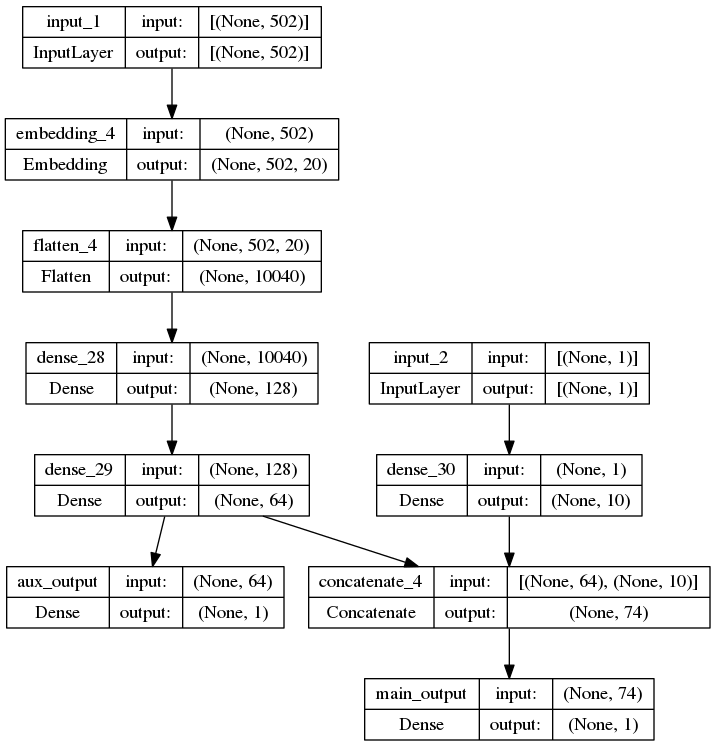

In [149]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
plot_model(model, to_file='model_lyrics.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='model_lyrics.png')

In [150]:
early_stopping = EarlyStopping(monitor = 'val_aux_output_loss', patience = 2)
# Train the model
model.fit([X1_train,X2_train], [y1_train,y2_train], batch_size=256, epochs=10, 
          validation_split=0.2,  callbacks = [early_stopping])

Epoch 1/10
483/483 [==============================] - 11s 19ms/step - loss: 1.2976 - aux_output_loss: 0.6522 - main_output_loss: 0.6454 - aux_output_mse: 0.0107 - main_output_mse: 0.0076 - val_loss: 1.2884 - val_aux_output_loss: 0.6523 - val_main_output_loss: 0.6361 - val_aux_output_mse: 0.0110 - val_main_output_mse: 0.0037
Epoch 2/10
483/483 [==============================] - 9s 19ms/step - loss: 1.2827 - aux_output_loss: 0.6514 - main_output_loss: 0.6313 - aux_output_mse: 0.0104 - main_output_mse: 0.0013 - val_loss: 1.2793 - val_aux_output_loss: 0.6511 - val_main_output_loss: 0.6281 - val_aux_output_mse: 0.0105 - val_main_output_mse: 2.6824e-04
Epoch 3/10
483/483 [==============================] - 9s 19ms/step - loss: 1.2796 - aux_output_loss: 0.6512 - main_output_loss: 0.6285 - aux_output_mse: 0.0103 - main_output_mse: 1.4457e-04 - val_loss: 1.2793 - val_aux_output_loss: 0.6512 - val_main_output_loss: 0.6281 - val_aux_output_mse: 0.0105 - val_main_output_mse: 2.6116e-04
Epoch 4/10
4

In [151]:
y1_pred,y2_pred = model.predict([X1_test,X2_test])

1206/1206 [==============================] - 3s 3ms/step


In [152]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score



# calculate mean absolute error (MAE)
mae1 = mean_absolute_error(y1_test, y1_pred)
mae2 = mean_absolute_error(y2_test, y2_pred)
print('MAE without artist familiarity:', mae1)
print('MAE with artist familiarity:', mae2)
print()
# calculate root mean squared error (RMSE)
rmse1 = mean_squared_error(y1_test, y1_pred, squared=False)
rmse2 = mean_squared_error(y2_test, y2_pred, squared=False)
print('RMSE without artist familiarity:', rmse1)
print('RMSE with artist familiarity:', rmse2)
print()
r2_1 = r2_score(y1_test, y1_pred)
r2_2 = r2_score(y2_test, y2_pred)
print('R-squared without artist familiarity:', rmse1)
print('R-squared with artist familiarity:', rmse2)

MAE without artist hotness: 0.08238995703810735
MAE with artist hotness: 0.013920472644883053

RMSE without artist hotness: 0.10284013395401942
RMSE with artist hotness: 0.015702841504479804

R-squared without artist hotness: 0.10284013395401942
R-squared with artist hotness: 0.015702841504479804


### SIMPLE NEURAL NETWORK 

In [153]:
from sklearn.feature_extraction.text import CountVectorizer
# Vectorize the lyrics text data
vectorizer = CountVectorizer(max_features=500)

lyrics_text = vectorizer.fit_transform(lyrics_metadata['text'])

# Combine the encoded categorical variables and the vectorized lyrics text data
X = np.hstack([
    lyrics_metadata[['artist_familiarity', 'total_words', 'total_unique_words']].values,
    lyrics_text.toarray()
])

y = lyrics_metadata['artist_hotttnesss'].values
X.shape

(192805, 503)

In [154]:
# Generate random indices
num_samples = X.shape[0]
indices = np.random.permutation(num_samples)

# Split indices into train and test
train_size = int(0.8 * num_samples)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Use indices to index data
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]
X_train.shape,X_test.shape

((154244, 503), (38561, 503))

### TRAINING A NEURAL NETWORK
*End Goal:-* Predict Artist Hotness with Artist Familiarity, Lyrics, word_counts, etc

In [155]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping


In [156]:

# Define the neural network architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 128)               64512     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_32 (Dense)            (None, 64)                8256      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_33 (Dense)            (None, 1)                 65        
                                                                 
Total params: 72,833
Trainable params: 72,833
Non-trainable params: 0
_________________________________________________________________


In [157]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2)
# Train the model
model.fit(X_train, y_train, batch_size=256, epochs=10, validation_split=0.2,  callbacks = [early_stopping])

Epoch 1/10
483/483 [==============================] - 3s 5ms/step - loss: 0.7728 - mse: 0.0218 - val_loss: 0.6878 - val_mse: 0.0067
Epoch 2/10
483/483 [==============================] - 2s 5ms/step - loss: 0.6875 - mse: 0.0066 - val_loss: 0.6871 - val_mse: 0.0063
Epoch 3/10
483/483 [==============================] - 2s 4ms/step - loss: 0.6871 - mse: 0.0064 - val_loss: 0.6869 - val_mse: 0.0062
Epoch 4/10
483/483 [==============================] - 2s 5ms/step - loss: 0.6869 - mse: 0.0063 - val_loss: 0.6867 - val_mse: 0.0061
Epoch 5/10
483/483 [==============================] - 2s 5ms/step - loss: 0.6869 - mse: 0.0063 - val_loss: 0.6866 - val_mse: 0.0061
Epoch 6/10
483/483 [==============================] - 2s 5ms/step - loss: 0.6867 - mse: 0.0062 - val_loss: 0.6875 - val_mse: 0.0065
Epoch 7/10
483/483 [==============================] - 2s 5ms/step - loss: 0.6866 - mse: 0.0061 - val_loss: 0.6865 - val_mse: 0.0060
Epoch 8/10
483/483 [==============================] - 2s 5ms/step - loss: 0.

In [158]:
y_pred = model.predict(X_test)
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}")

1206/1206 [==============================] - 2s 2ms/step - loss: 0.6824 - mse: 0.0040
Test loss: 0.6824


In [159]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

# calculate mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# calculate root mean squared error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# calculate R-squared error (R2)
r2 = r2_score(y_test, y_pred)

print('MAE:', mae)
print('RMSE:', rmse)
print('R-Squared:', r2)

MAE: 0.0484970031324861
RMSE: 0.06342525341835656
R-Squared: 0.38094007143428177


### TRAINING ML models

In [160]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [164]:
# Fit the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [165]:
# Predict on the test data using the Random Forest model
rf_pred = rf.predict(X_test)

# Calculate the RMSE for the Random Forest model
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)


In [166]:
# Fit the XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=50, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=50, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [167]:
# Predict on the test data using the XGBoost model
xgb_pred = xgb_model.predict(X_test)

# Calculate the RMSE for the XGBoost model
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))

xgb_r2 = r2_score(y_test, xgb_pred)


In [168]:
print("Random Forest RMSE: ", rf_rmse)
print("XGBoost RMSE: ", xgb_rmse)
print()
print("Random Forest R2: ", rf_r2)
print("XGBoost R2: ", xgb_r2)


Random Forest RMSE:  0.0284707835382196
XGBoost RMSE:  0.02802921371410482

Random Forest R2:  0.8752596064624008
XGBoost R2:  0.8790989421405395
